# Loading in our data from main.ipynb to build the deeper model

### Loading the data

In [10]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

with open("prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]
class_weights_dict = data["class_weights"]
num_classes = data["num_classes"]

### Building the model

In [11]:
def build_cnn(num_classes):
    weight_decay = 1e-4
    inputs = Input(shape=(32, 32, 3))
    out = Conv2D(64, (3,3), padding='same', activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(inputs)
    out = BatchNormalization()(out)
    out = Conv2D(64, (3,3), padding='same', activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(out)
    out = BatchNormalization()(out)

    skip = Conv2D(64, (1,1), padding='same')(inputs)
    out = Add()([out, skip])
    out = Activation("relu")(out)

    out = MaxPooling2D(2,2)(out)
    out = Dropout(0.25)(out)


    block2 = Conv2D(128, (3,3), padding='same', activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(out)
    block2 = BatchNormalization()(block2)

    block2 = Conv2D(128, (3,3), padding='same', activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(block2)
    block2 = BatchNormalization()(block2)

    skip2 = Conv2D(128, (1,1), padding='same')(out)
    out = Add()([block2, skip2])
    out = Activation("relu")(out)

    out = MaxPooling2D(2,2)(out)
    out = Dropout(0.25)(out)

    block3 = Conv2D(256, (3,3), padding='same', activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(out)
    block3 = BatchNormalization()(block3)

    block3 = Conv2D(256, (3,3), padding='same', activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(block3)
    block3 = BatchNormalization()(block3)

    skip3 = Conv2D(256, (1,1), padding='same')(out)
    out = Add()([block3, skip3])
    out = Activation("relu")(out)

    out = MaxPooling2D(2,2)(out)
    out = Dropout(0.25)(out)


    out = GlobalAveragePooling2D()(out)

    out = Dense(512, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dropout(0.5)(out)

    outputs = Dense(num_classes, activation='softmax')(out)

    return Model(inputs, outputs)


### Parameters and addressing under/overfitting

In [12]:
model = build_cnn(num_classes)

# Added Cosine Decay Learning Rate Schedule
# Allows the learning rate to start high and gradually decrease
# Helps escape sharp minimal and converge better
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0007,
    decay_steps=40000
)

optimizer = Adam(learning_rate=lr_schedule)

# Added label smoothing
# Reduces overconfidence of predictions
# Provides measurable accuracy gains on CIFAR datasets
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

model.summary()

# Increased patience for smoother cosine LR
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │        256 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │      8,320 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 16,    │          0 │ add_4[0][0]     

 Total params: 1,336,536 (5.10 MB)

 Trainable params: 1,333,720 (5.09 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Data augmentation

In [13]:
batch_size = 64
epochs = 50

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, [32, 32, 3])
    return image, label

# Added labels one-hot encoding
# This improved model uses CategoricalCrossentropy with label smoothing,
# which requires labels to be in one-hot format instead of integer class IDs.
# The original model used SparseCategoricalCrossentropy, which accepts
# integer labels directly, so one-hot encoding was not needed.
# Converting labels here ensures compatibility with the new loss function
# and enables more stable training with label smoothing.
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(10000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),  num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


### Training the model

In [14]:
print("Training the model...")

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)


print("Evaluating on test set...")

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training the model...
Epoch 1/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.1202 - loss: 2.7446 - val_accuracy: 0.1402 - val_loss: 3.1583
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.2650 - loss: 2.1615 - val_accuracy: 0.3380 - val_loss: 2.3309
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3776 - loss: 1.8941 - val_accuracy: 0.4035 - val_loss: 2.1733
Epoch 4/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4640 - loss: 1.7112 - val_accuracy: 0.4884 - val_loss: 1.9454
Epoch 5/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5155 - loss: 1.6010 - val_accuracy: 0.5156 - val_loss: 1.8397
Epoch 6/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5495 - loss: 1.5362 - val_accuracy: 0.5549 - val_loss: 1.7649
Epoch 7/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5763 - loss: 1.4750 - val_accuracy: 0.5798 - val_loss: 1.7271
Epoch 8/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.

### Plotting Training History

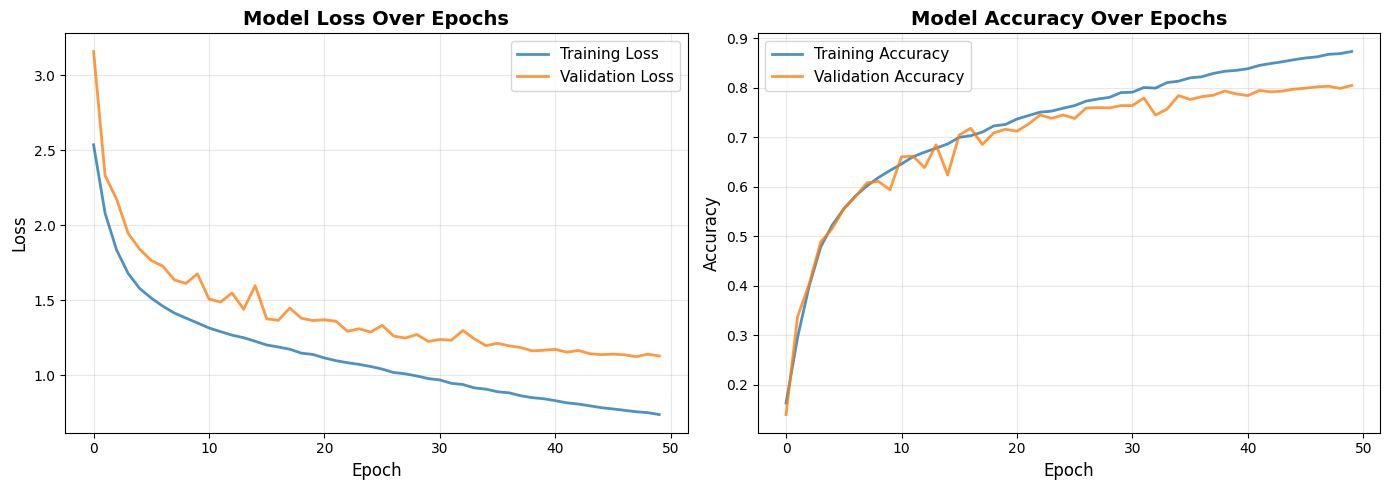

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Image Testing

Found 1000 samples for class 2


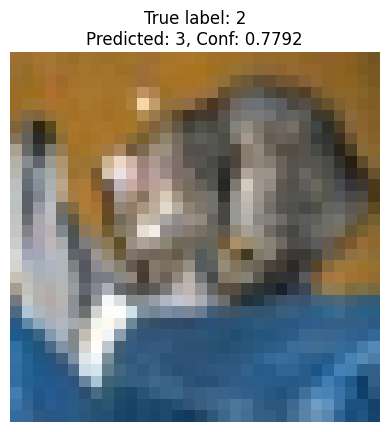


Top-5 predicted classes:
Class 3: 0.7792
Class 2: 0.0854
Class 19: 0.0317
Class 23: 0.0266
Class 1: 0.0153


In [16]:
# Choose the class you want to inspect
sample_class = 2   # change this freely

# Find test samples that belong to this raw class
indices = np.where(y_test == sample_class)[0]
print(f"Found {len(indices)} samples for class {sample_class}")

# Pick any sample you want (first one)
sample_idx = indices[0]

sample_img = X_test[sample_idx]
sample_label = y_test[sample_idx]

# Preprocess exactly like training
img = tf.cast(sample_img, tf.float32) / 255.0
img = tf.expand_dims(img, axis=0)

# Predict
pred = model.predict(img, verbose=0)[0]

predicted_class = int(np.argmax(pred))
confidence = float(np.max(pred))

# Display the image
plt.imshow(sample_img.astype("uint8"))
plt.axis("off")
plt.title(
    f"True label: {sample_label}\n"
    f"Predicted: {predicted_class}, Conf: {confidence:.4f}"
)
plt.show()

# Top-5 predictions
top5 = np.argsort(pred)[-5:][::-1]

print("\nTop-5 predicted classes:")
for idx in top5:
    print(f"Class {idx}: {pred[idx]:.4f}")

## Summary for model_tuning_1.ipynb
With model_building_2.ipynb as the base model, we introduced L2 regularization to reduce overfitting. Helps gradients flow better and prevents degradation in deeper networks.  
Added GlobalAveragePooling instead of Flatten. Reduces parameters and improves generalization.  
Added Cosine Decay Learning Rate Schedule. Allows the learning rate to start high and gradually decrease. Helps escape sharp minimal and converge better.  
Added label smoothing. Reduces overconfidence of predictions. Provides measurable accuracy gains on CIFAR datasets.  
Increased patience for smoother cosine LR.  
Removed brightness and contrast (too strong for 32×32 images).  
Added labels one-hot encoding. This improved model uses CategoricalCrossentropy with label smoothing, which requires labels to be in one-hot format instead of integer class IDs.  
The original model used SparseCategoricalCrossentropy, which accepts integer labels directly, so one-hot encoding was not needed. Converting labels here ensures compatibility with the new loss function and enables more stable training with label smoothing.
